# ATLAS *Z*+jets MultiFold: Measurement

This notebook presents an unbinned and high-dimensional measurement of $Z$+jets differential cross sections based on 
the OmniFold method [arXiv:1911.09107](https://arxiv.org/abs/1911.09107). The measurement is based on the full Run 2 ATLAS $pp$ dataset at $\sqrt{s}=13$ TeV and is fully corrected for detector effects, i.e. unfolded to the particle (truth) level. 

While a [dedicated notebook provides technical setup instructions and demonstrates basic usage](./1_basics.ipynb), this notebook gives examples of more advanced usage, such as how to obtain binned differential cross-sections and access the associated covariance matrices. We recommend that users first look at the [measurement of pseudo-data](./2_pseudo_results.ipynb) before looking at this notebook. 

## 1. Initialization and loading of the data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd 
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
import pickle
from multifold_util import *

In [2]:
top_folder = "./files/"

print("Loading the measurement - based on actual data.")
folder = os.path.join(top_folder, "data")
plot_dir = os.path.join(os.getcwd(), "plots", "data")
os.makedirs(plot_dir, exist_ok=True)

# Nominal measurement of data (using the MG5 for unfolding)
multifold = pd.read_hdf(os.path.join(folder,"multifold.h5"))
# Measurement of data using alternative MC samples. 
multifold_sherpa = pd.read_hdf(os.path.join(folder,"multifold_sherpa.h5"))
multifold_nonDY  = pd.read_hdf(os.path.join(folder,"multifold_nonDY.h5"))
mc_preds = np.load(os.path.join(folder,"mc_preds.npy"), allow_pickle=True)

Loading the measurement - based on actual data.


In [3]:
### Construct masks for track pT cuts
mask_trackj1 = np.array(multifold['pT_trackj1'] > 5, dtype='bool')
mask_trackj2 = np.array(multifold['pT_trackj2'] > 5, dtype='bool')

mask_sherpa_trackj1 = np.array(multifold_sherpa['pT_trackj1'] > 5, dtype='bool')
mask_sherpa_trackj2 = np.array(multifold_sherpa['pT_trackj2'] > 5, dtype='bool')

mask_nonDY_trackj1 = np.array(multifold_nonDY['pT_trackj1'] > 5, dtype='bool')
mask_nonDY_trackj2 = np.array(multifold_nonDY['pT_trackj2'] > 5, dtype='bool')

## 2. Choice of variables and binning

An inherent advantage to MultiFold is that it performs an *unbinned* unfolding, meaning we can adjust the bins as we please. However, as stated in the supplementary material of the paper, the chosen binning should fulfill two conditions: sufficient statistical precision specified by $N_\text{eff} > 5000$; and, sufficient support by actual data by requiring a data statistical uncertainty smaller than 15%. These criteria are implemented in the [equal_effective_statistics method in the utility file](./multifold_util.py).

As part of the analysis, we compared the unbinned results with results obtained using the traditional unfolding technique: Iterative Bayesian Unfolding (IBU). We settled on a binning adequate for IBU, which is loaded in the box below. This binning is used for the results produced in this notebook and is also what is used for the results shown in the paper.

In [4]:
bins_dict = ibu_bins # defined in demo_functions.py
# bins_dict['Ntracks_trackj1'] = [0.5, 2] # example of how to modify binning for a given variable

print(f"Loaded bins for {len(bins_dict)} observables:")
for obs, bins in bins_dict.items():
    print("{:>15} with {:2} bins [{:.1f} ... {:.1f}]".format(obs,len(bins),bins[0],bins[-1]))
    # print("  {}, {} bins: {}".format(obs,len(bins),bins))

Loaded bins for 24 observables:
          pT_l1 with  7 bins [25.0 ... 800.0]
          pT_l2 with  7 bins [25.0 ... 400.0]
         eta_l1 with 15 bins [-2.5 ... 2.5]
         eta_l2 with 15 bins [-2.5 ... 2.5]
         phi_l1 with 17 bins [-3.1 ... 3.1]
         phi_l2 with 17 bins [-3.1 ... 3.1]
     pT_trackj1 with  7 bins [5.0 ... 1000.0]
     pT_trackj2 with  5 bins [5.0 ... 500.0]
      y_trackj1 with 19 bins [-2.5 ... 2.5]
      y_trackj2 with 11 bins [-2.5 ... 2.5]
    phi_trackj1 with 17 bins [-3.1 ... 3.1]
    phi_trackj2 with 17 bins [-3.1 ... 3.1]
          pT_ll with  6 bins [200.0 ... 1000.0]
           y_ll with 15 bins [-2.5 ... 2.5]
Ntracks_trackj1 with  7 bins [0.5 ... 39.5]
Ntracks_trackj2 with  6 bins [0.5 ... 34.5]
      m_trackj1 with  7 bins [0.0 ... 70.0]
      m_trackj2 with  5 bins [0.0 ... 40.0]
   tau1_trackj1 with  8 bins [0.0 ... 0.9]
   tau1_trackj2 with  6 bins [0.0 ... 0.9]
   tau2_trackj1 with  8 bins [0.0 ... 0.5]
   tau2_trackj2 with  6 bins [0.0 ..

# Results of the 24 directly measured observables

## 3. Calculation of uncertainties

The next two code blocks first creates groups of uncertainites for dedicated uncertainty plots.

Next, uncertainties are loaded or calculated such that they can be accessed for the result plots.
Uncertainties for all 24 unfolded observables are calculated using the binning defined above.

In [5]:
# List of systematic uncertainties, stored as weights in the dataset
event_systs     = [col for col in multifold.keys() if col.startswith("weights_muEff")] + ['weights_pileup']
theory_systs    = [col for col in multifold.keys() if col.startswith("weights_theory")]
track_systs     = [col for col in multifold.keys() if col.startswith("weights_track")]
muon_systs      = [col for col in multifold.keys() if col.startswith("weights_muCal")]

# List of stochastic uncertainty names
mc_stat_systs   = [col for col in multifold.keys() if col.startswith("weights_bootstrap_mc")]
data_stat_systs = [col for col in multifold.keys() if col.startswith("weights_bootstrap_data")]
ensemble_systs  = [col for col in multifold.keys() if col.startswith("weights_ensemble")]

In [6]:
if os.path.exists(os.getcwd()+'/data_uncertainties.p'):
    print("Using pre-calculated uncertainties.") 
    uncertainties = np.load(os.getcwd()+'/data_uncertainties.p', allow_pickle=True)
else:
    print("Calculating uncertainties from scratch.")
    uncertainties = {}

    for i in tqdm(range(24), desc="Unfolded vars"): # number of unfolded vars
        var = list(bins_dict.items())[i][0]
        bins = np.array(list(bins_dict.items())[i][1])
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        if "trackj1" in var: 
            df = multifold[mask_trackj1]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj1]
        elif "trackj2" in var:
            df = multifold[mask_trackj2]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj2]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj2]
        else:
            df = multifold
            df_sherpa = multifold_sherpa
            df_nonDY = multifold_nonDY

        nom, _ = np.histogram(df[var], bins=bins, weights=df.weights_nominal)    
        final_event          = calculate_uncertainty(df, var, bins, event_systs)
        final_theory         = calculate_uncertainty(df, var, bins, theory_systs)
        final_track          = calculate_uncertainty(df, var, bins, track_systs)
        final_muon           = calculate_uncertainty(df, var, bins, muon_systs)
        final_mc_stat        = calculate_stat_uncertainty(df, var, bins, mc_stat_systs)
        final_data_stat      = calculate_stat_uncertainty(df, var, bins, data_stat_systs)
        final_nn_init        = calculate_stat_uncertainty(df, var, bins, ensemble_systs)/np.sqrt(len(ensemble_systs))

        ### Unfolding (DD)
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_dd)
        target_dd, _ = np.histogram(df[var], bins=bins, weights=df.target_dd)
        final_unfolding_dd = 100*np.sqrt((syst-target_dd)**2)/target_dd

        ### Unfolding (HV)
        syst, _ = np.histogram(df_sherpa[var], bins=bins, weights=df_sherpa.weights_nominal)
        smoothed_hv_syst_signed = smooth_uncertainty(syst-nom, bin_centers)
        final_unfolding_hv = 100*np.sqrt((smoothed_hv_syst_signed)**2)/nom

        ### Sum these together in quadrature
        final_unfolding = np.sqrt(final_unfolding_hv**2 + final_unfolding_dd**2)

        ### Luminosity 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_lumi)
        final_lumi = 100*np.sqrt((syst-nom)**2)/nom

        ### Top Background 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_topBackground)
        final_top = 100*np.sqrt((syst-nom)**2)/nom

        ### Non-Strong Background
        syst, _ = np.histogram(df_nonDY[var], bins=bins, weights=df_nonDY.weights_nominal)
        final_nonDY = 100*np.sqrt((syst-nom)**2)/nom

        final_exp = np.sqrt(final_lumi**2 + final_muon**2 + final_track**2 + final_event**2)
        uncertainties[var+"_exp"] = final_exp
        uncertainties[var+"_theory"] = final_theory
        uncertainties[var+"_mc_stat"] = np.sqrt(final_mc_stat**2 + final_nn_init**2)
        uncertainties[var+"_data_stat"] = final_data_stat
        uncertainties[var+"_unfolding"] = final_unfolding
        uncertainties[var+"_top"] = final_top
        uncertainties[var+"_nonDY"] = final_nonDY

        total = np.sqrt(
            + final_theory**2 
            + final_exp**2
            + final_mc_stat**2
            + final_data_stat**2
            + final_unfolding**2
            + final_top**2
            + final_nonDY**2
        )
        
        uncertainties[var+"_total"] = total

Using pre-calculated uncertainties.


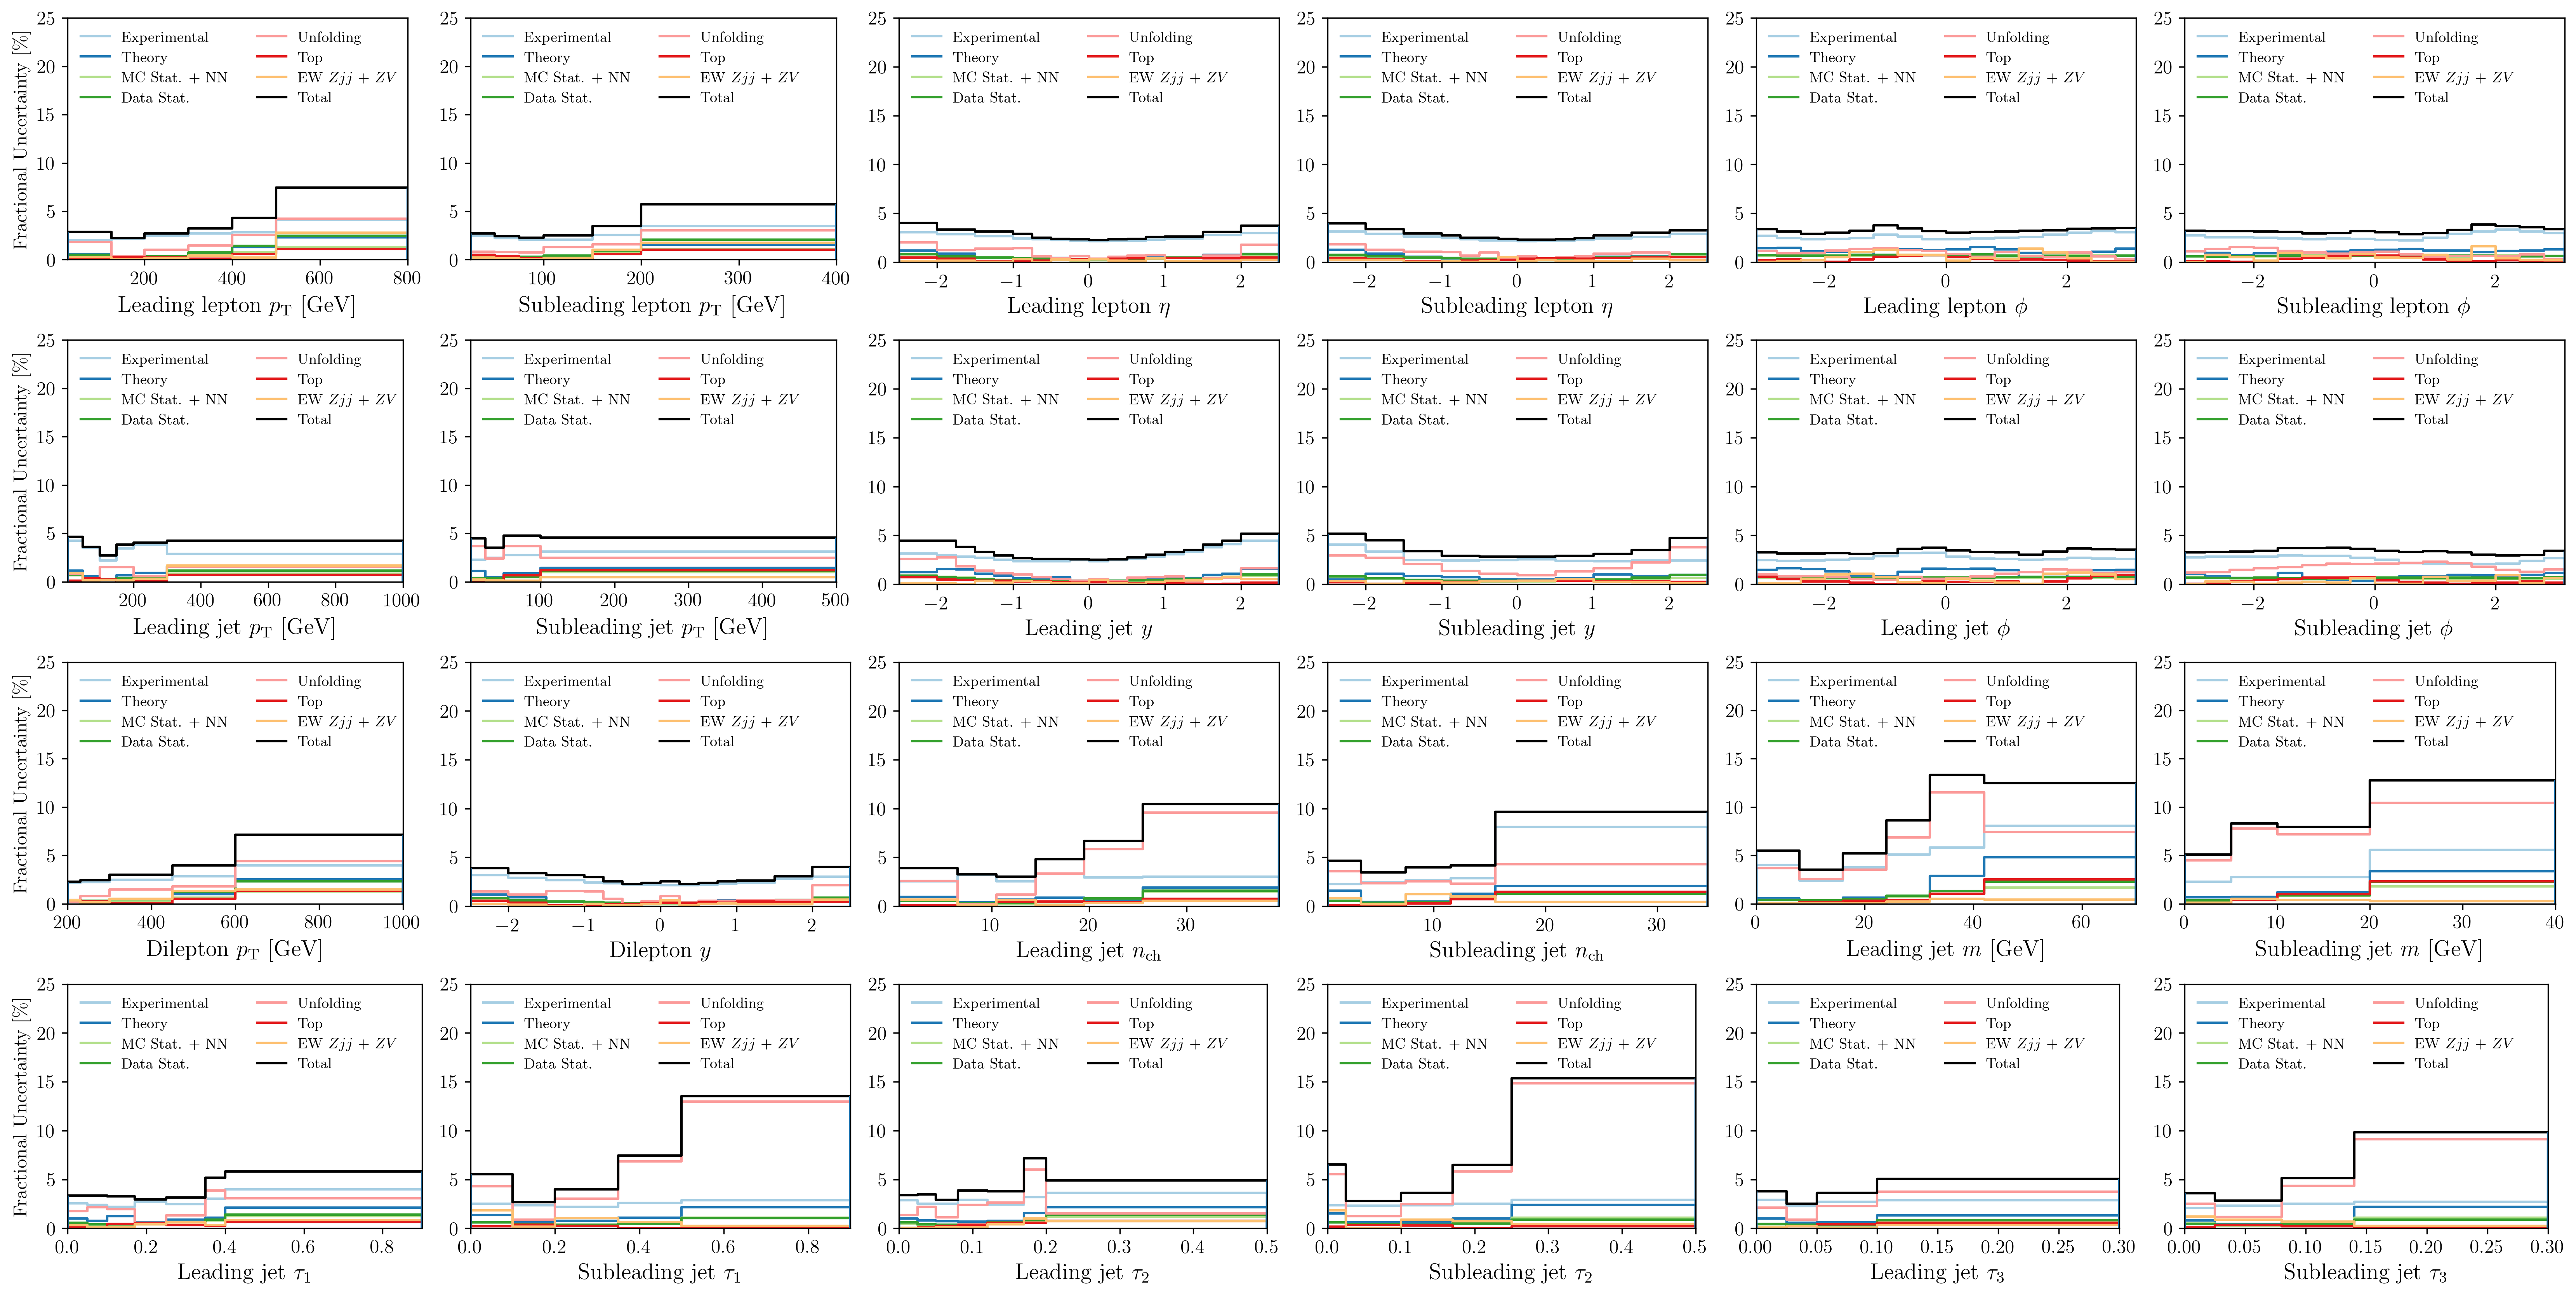

In [7]:
fig = plt.figure(figsize=(22,11), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(4, 6)

for i, subfig in enumerate(subfigs.flat):
    ax = subfig.subplots(1, 1)
    colors = [plt.cm.Paired(i) for i in range(20)]
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])

    ax.step(bins, np.concatenate([[uncertainties[var+'_exp'][0]],uncertainties[var+'_exp']]),              label = "Experimental",       color=colors[0],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_theory'][0]],uncertainties[var+'_theory']]),        label = "Theory",             color=colors[1],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_mc_stat'][0]],uncertainties[var+'_mc_stat']]),      label = "MC Stat. + NN",      color=colors[2],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_data_stat'][0]],uncertainties[var+'_data_stat']]),  label = "Data Stat.",         color=colors[3],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_unfolding'][0]],uncertainties[var+'_unfolding']]),  label = "Unfolding",          color=colors[4]     )
    ax.step(bins, np.concatenate([[uncertainties[var+'_top'][0]],uncertainties[var+'_top']]),              label = "Top",                color=colors[5],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_nonDY'][0]],uncertainties[var+'_nonDY']]),          label = r"EW $Zjj$ + $ZV$",   color=colors[6],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_total'][0]],uncertainties[var+'_total']]),          label = "Total",              color='black',      )

    ### draw lines at the beginning and end of the first and last bins, for plotting purposes
    label_list = ['exp', 'theory', 'mc_stat', 'data_stat', 'unfolding', 'top', 'nonDY', 'total']
    for label in label_list:
        plt.vlines(x=bins[0], ymin=0, ymax=uncertainties[var+'_'+label][0])
        plt.vlines(x=bins[-1], ymin=0, ymax=uncertainties[var+'_'+label][-1])

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    if i % 6 == 0: ax.set_ylabel(r"Fractional Uncertainty [\%]", fontsize=12)
    ax.legend(fontsize=9, loc='upper left', ncol=2, frameon=False)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 25])
    ax.set_xlabel(plot_labels[var], fontsize=14);
    
plt.savefig(os.path.join(plot_dir,"total_systs.pdf"))

### Plot results

Plots: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]


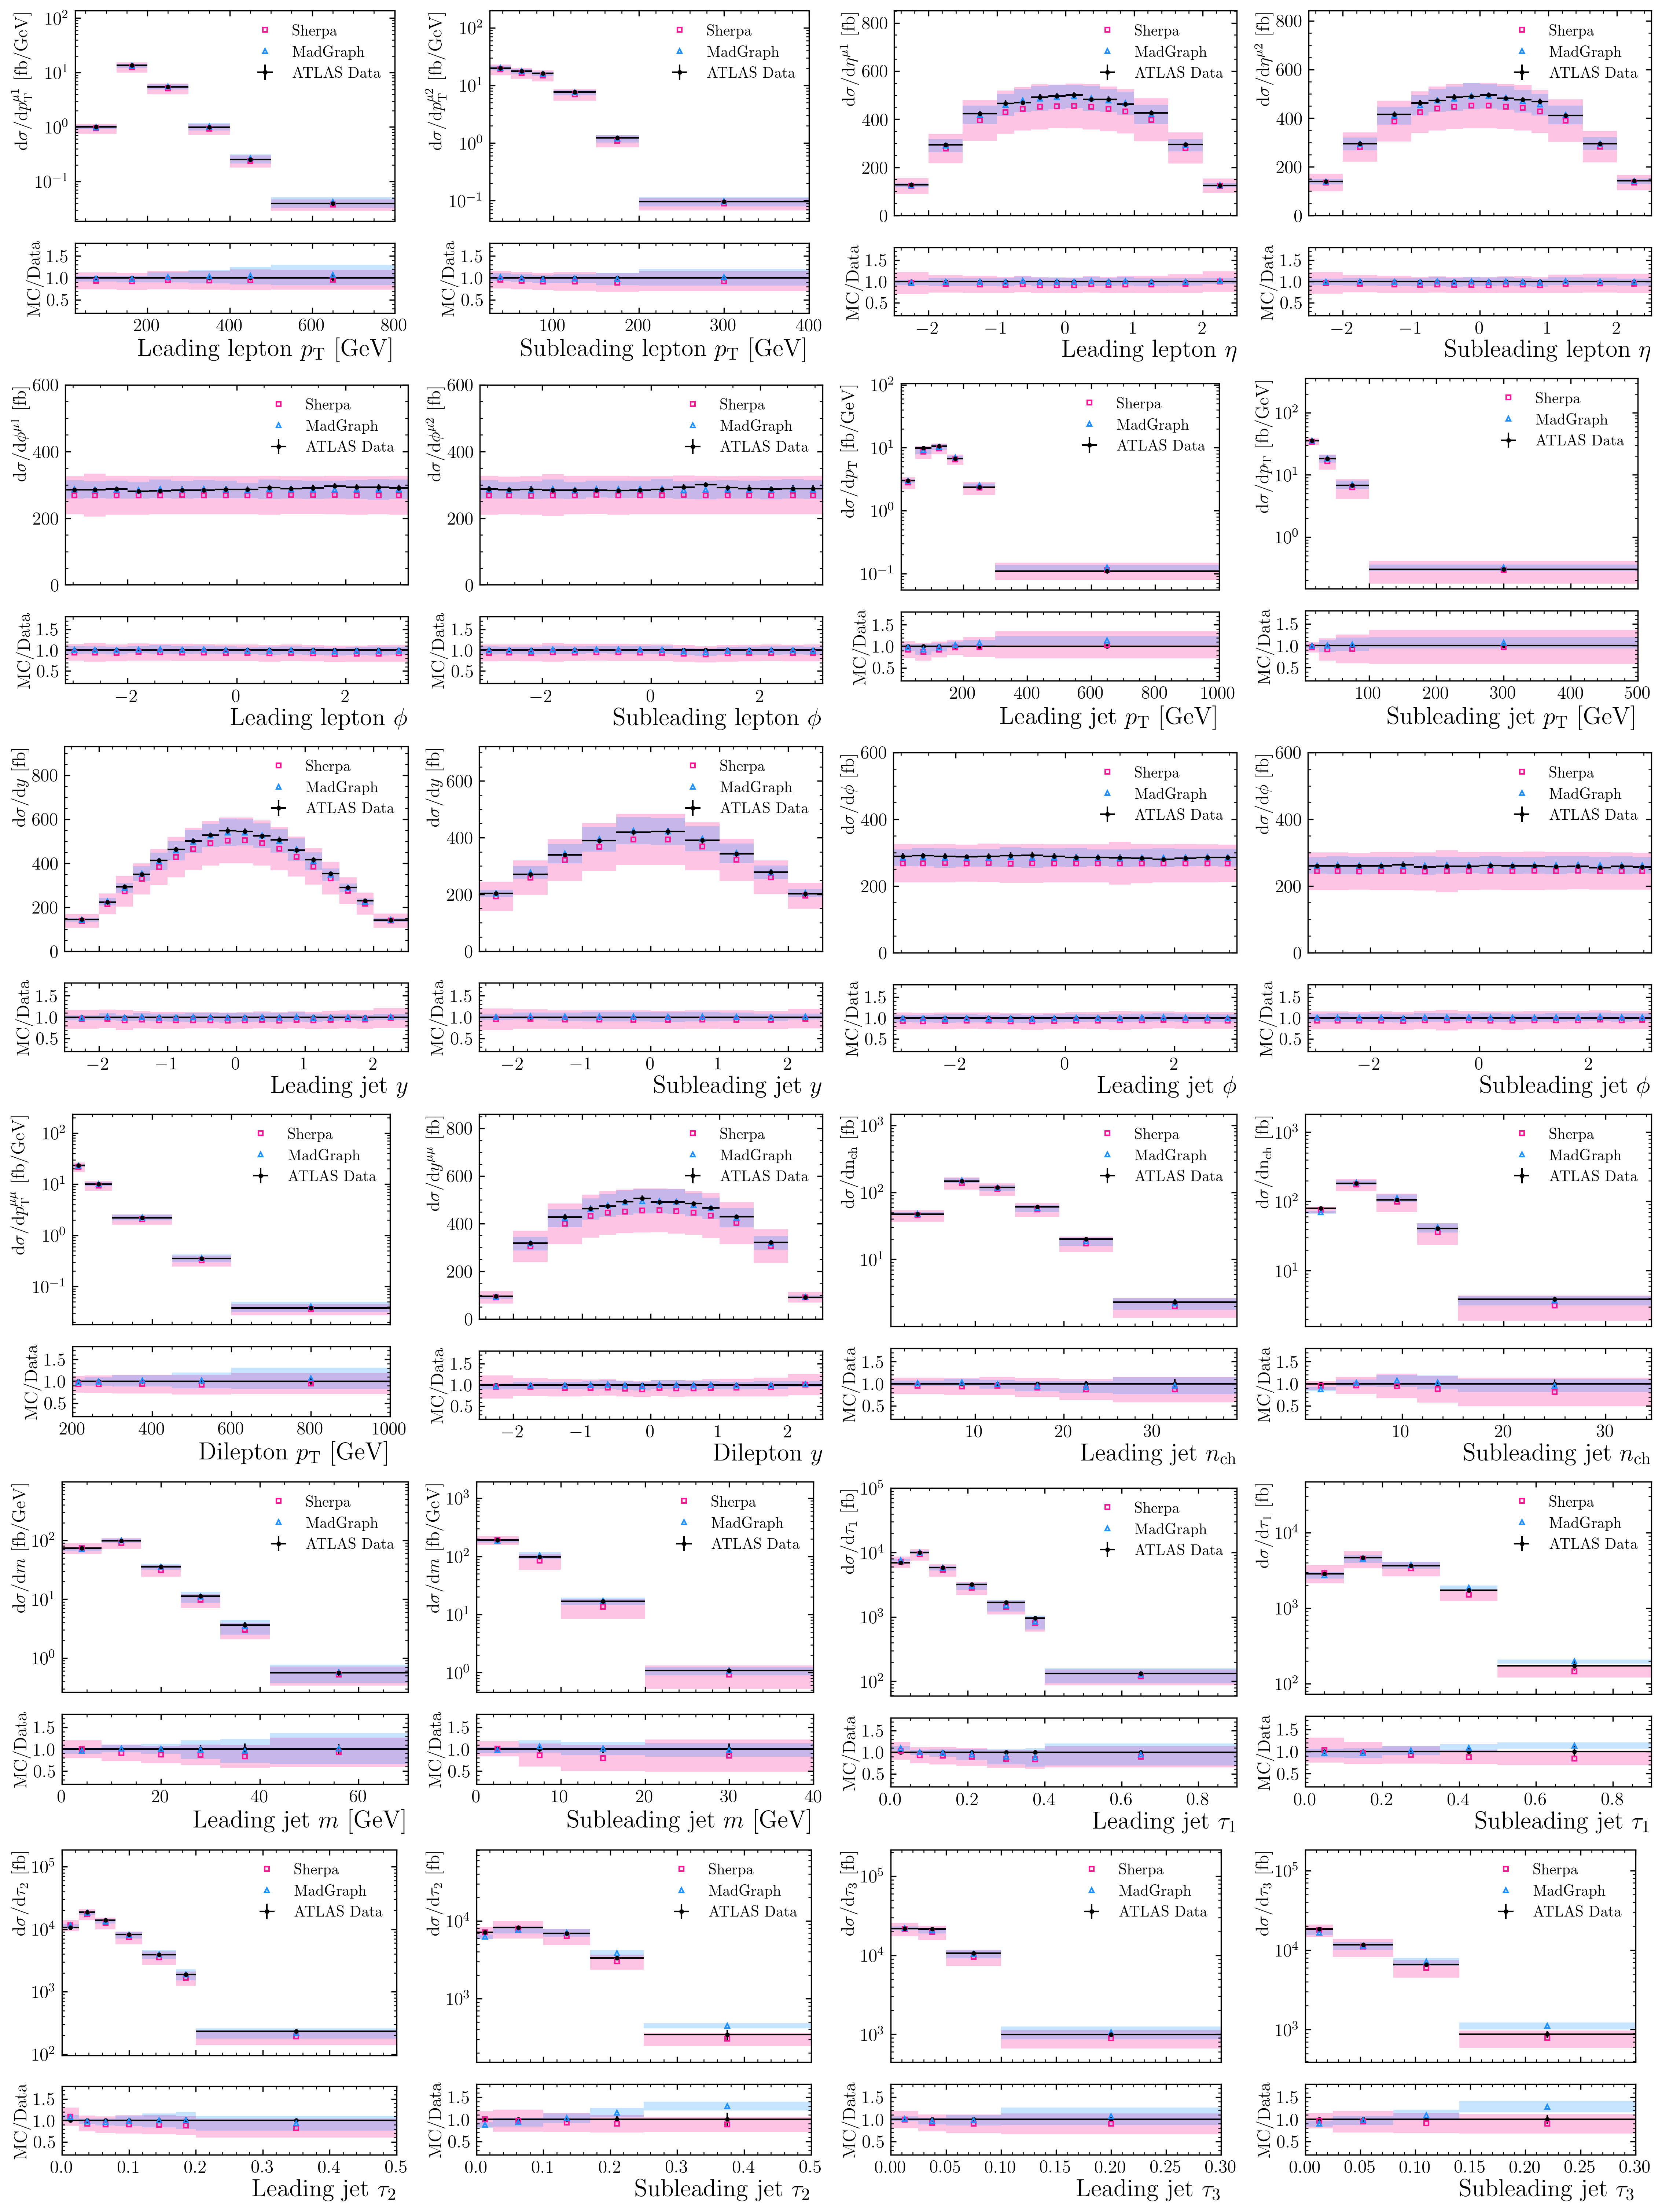

In [8]:
fig = plt.figure(figsize=(15,20), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(6, 4)

for i, subfig in enumerate(tqdm(subfigs.flat, desc="Plots")):  
    axs = subfig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])
    
    if "trackj1" in var: 
        df = multifold[mask_trackj1]
    elif "trackj2" in var:
        df = multifold[mask_trackj2]
    else:
        df = multifold    
    
    ### Sherpa
    counts = mc_preds[i]['sherpa_counts']
    sherpa_density = counts/lumi/bin_widths
    sherpa_error = mc_preds[i]['sherpa_err']/mc_preds[i]['sherpa_counts']
    _ = make_error_boxes(axs[0], bin_centers, sherpa_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([sherpa_density*sherpa_error, sherpa_density*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label=r'Sherpa',)
    
    ### MGFxFx 
    counts = mc_preds[i]['mgfxfx_counts']
    mgfxfx_density = counts/lumi/bin_widths
    mgfxfx_error = mc_preds[i]['mgfxfx_err']/mc_preds[i]['mgfxfx_counts']
    _ = make_error_boxes(axs[0], bin_centers, mgfxfx_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([mgfxfx_density*mgfxfx_error, mgfxfx_density*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label=r'MadGraph')

    ### MultiFold
    multifold_density, _, _ = axs[0].hist(df[var], weights=df.weights_nominal, bins=bins, color='black', linewidth= 2, density=True, alpha=0)
    multifold_density *= np.sum(df.weights_nominal)
    
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[0].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[0].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[0].set_ylabel(labels[var], fontsize=12, labelpad=2, loc='top')
    axs[0].set_ylim([0, 1.7 * max(max(mgfxfx_density), max(multifold_density))])
    
    ### Set some plots to use log y scale
    if 'phi' not in var and 'eta' not in var and 'y' not in var:
        axs[0].set_yscale('log')
        axs[0].set_ylim([0.5*min(min(sherpa_density), min(multifold_density)), 10 * max(max(sherpa_density), max(multifold_density))])
    
    elif 'phi' in var:
        axs[0].set_ylim(0,600)

    axs[0].errorbar(bin_centers, multifold_density, xerr=bin_widths/2, yerr=multifold_density*uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label="ATLAS Data", markersize=4, linewidth=1)
    axs[0].legend(fontsize=10, frameon=False, loc='best');
    axs[1].errorbar(bin_centers, np.ones(len(bin_centers)), xerr=bin_widths/2, yerr=uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1,  ecolor='k', label="ATLAS Data", markersize=4, linewidth=1)
    _ = make_error_boxes(axs[1], bin_centers, sherpa_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(sherpa_density/multifold_density)*sherpa_error, (sherpa_density/multifold_density)*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label=r'Sherpa')
    _ = make_error_boxes(axs[1], bin_centers, mgfxfx_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(mgfxfx_density/multifold_density)*mgfxfx_error, (mgfxfx_density/multifold_density)*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label=r'MadGraph')
    axs[1].set_xlim(bins[0], bins[-1])
    axs[1].set_ylim([0.2,1.8])
    axs[1].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[1].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[1].set_ylabel('MC/Data', fontsize=12, labelpad=2, loc='center')
    axs[1].set_xlabel(plot_labels[var], fontsize=16, labelpad=2, loc='right');
    
plt.savefig(os.path.join(plot_dir,"nominal_diff_xsec.pdf"))

# Derived variable results

Now we'll calculate two additional variables that weren't present in the 24-dimensional unfolding, but are combinations of the unfolded variables: 

1. $\tau_{21} \equiv \tau_2/\tau_1$
2. $\Delta R(j_1, ll)$

In [9]:
### Define new variables
def calculate_vars(df): 
    ### tau21 = tau2/tau1 
    df['tau21'] = df.tau2_trackj1/df.tau1_trackj1

    ### deltaR(ll, j1) 
    def dR(v1, v2):
        dy = v1.rapidity-v2.rapidity
        dphi = v1.deltaphi(v2)
        return np.sqrt(dy**2 + dphi**2)

    def dR_ll_trackj1(pT_l1, eta_l1, phi_l1, 
                      pT_l2, eta_l2, phi_l2, 
                      pT_trackj1, y_trackj1, phi_trackj1):
        l1 = vector.array({
            "pt": pT_l1,
            "phi": phi_l1,
            "eta": eta_l1,
            "m":np.zeros_like(pT_l1)
        })
        l2 = vector.array({
            "pt": pT_l2,
            "phi": phi_l2,
            "eta": eta_l2,
            "m":np.zeros_like(pT_l2)
        })
        track_j1 = vector.array({
            "pt": pT_trackj1,
            "phi": phi_trackj1,
            "eta": y_trackj1,
            "m":np.zeros_like(pT_trackj1)
        })

        ll = l1 + l2
        return dR(ll, track_j1)
    
    def phi_ll(pt_l1, eta_l1, phi_l1, pt_l2, eta_l2, phi_l2): 
            l1 = vector.array({"pt": pt_l1, "eta": eta_l1, "phi": phi_l1, "m": np.zeros(len(pt_l1))})
            l2 = vector.array({"pt": pt_l2, "eta": eta_l2, "phi": phi_l2, "m": np.zeros(len(pt_l2))})
            return l1.add(l2).phi
    
    df['phi_ll'] = phi_ll(np.array(df.pT_l1), np.array(df.eta_l1), np.array(df.phi_l1), 
                          np.array(df.pT_l2), np.array(df.eta_l2), np.array(df.phi_l2))
    df['dR_ll'] = dR_ll_trackj1(
        np.array(df.pT_l1), np.array(df.eta_l1), np.array(df.phi_l1), 
        np.array(df.pT_l2), np.array(df.eta_l2), np.array(df.phi_l2),
        np.array(df.pT_trackj1), np.array(df.y_trackj1), np.array(df.phi_trackj1))
    
    return df

### Pick bins for each of these new variables
### (Don't know which bins to pick? Look at the code in the cell below!)
bins_dict['tau21'] = [0.0, 0.35, 0.51, 0.63, 0.71, 0.78, 1.0]
bins_dict['dR_ll'] = [0.0, 2.0, 2.4, 2.6, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.6, 4.0, 6.0]

### Define plot labels
plot_labels['tau21'] = r'$\tau_2/\tau_1$'
plot_labels['dR_ll'] = r'$\Delta R(ll,j_1)$'
labels['tau21'] = r'd$\sigma$/d$\tau_{21}$ [fb]'
labels['dR_ll'] = r'd$\sigma$/d$\Delta R_{ll}$ [fb]'

### Add these new variables to each dataset
for dataframe in tqdm([multifold, multifold_sherpa, multifold_nonDY], desc="Calculating..."): 
    dataframe = calculate_vars(dataframe)

Calculating...: 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]


### *Optional*: Creating an automatic binning with a given number of effective events

In [10]:
N = 10_000  # Number of effective events per bin
var = 'tau21'
bin_edges = equal_effective_events_bins(multifold, var, N)
print(bin_edges)

Dividing into 19 bins of 10000 effective events.


100%|██████████| 418014/418014 [00:10<00:00, 39555.47it/s]

[0.0, 0.28988584876060486, 0.3640653192996979, 0.41751012206077576, 0.4589247405529022, 0.49354755878448486, 0.5223435163497925, 0.54822838306427, 0.5715741515159607, 0.5922552943229675, 0.6122745275497437, 0.6310641765594482, 0.6485280990600586, 0.6656171083450317, 0.6826119422912598, 0.6997202038764954, 0.7169000506401062, 0.7355999946594238, 0.7582346796989441, 0.9162741]


### Calculate uncertainties

In [11]:
if os.path.exists(os.getcwd()+'/data_uncertainties.p'):
    print("Using pre-calculated uncertainties.") 
else:
    print("Calculating uncertainties.")
    
    n_derived_vars = len(labels) - 24

    for i in tqdm(range(24,24+n_derived_vars), desc="Unfolded vars"): # number of unfolded vars
        var = list(bins_dict.items())[i][0]
        bins = np.array(list(bins_dict.items())[i][1])
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        if var == "tau21" or var == "dR_ll":
            df = multifold[mask_trackj1]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj1]
        else:
            df = multifold
            df_sherpa = multifold_sherpa
            df_nonDY = multifold_nonDY
    
        nom, _ = np.histogram(multifold[var], bins=bins, weights=multifold.weights_nominal)    
        final_event          = calculate_uncertainty(multifold, var, bins, event_systs)
        final_theory         = calculate_uncertainty(multifold, var, bins, theory_systs)
        final_track          = calculate_uncertainty(multifold, var, bins, track_systs)
        final_muon           = calculate_uncertainty(multifold, var, bins, muon_systs)
        final_mc_stat        = calculate_stat_uncertainty(multifold, var, bins, mc_stat_systs)
        final_data_stat      = calculate_stat_uncertainty(multifold, var, bins, data_stat_systs)
        final_nn_init        = calculate_stat_uncertainty(multifold, var, bins, ensemble_systs)/np.sqrt(len(ensemble_systs))

        ### Unfolding (DD)
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_dd)
        target_dd, _ = np.histogram(df[var], bins=bins, weights=df.target_dd)
        final_unfolding_dd = 100*np.sqrt((syst-target_dd)**2)/target_dd

        ### Unfolding (HV)
        syst, _ = np.histogram(df_sherpa[var], bins=bins, weights=df_sherpa.weights_nominal)
        smoothed_hv_syst_signed = smooth_uncertainty(syst-nom, bin_centers)
        final_unfolding_hv = 100*np.sqrt((smoothed_hv_syst_signed)**2)/nom

        ### Sum these together in quadrature
        final_unfolding = np.sqrt(final_unfolding_hv**2 + final_unfolding_dd**2)

        ### Luminosity 
        syst, _ = np.histogram(multifold[var], bins=bins, weights=multifold.weights_lumi)
        final_lumi = 100*np.sqrt((syst-nom)**2)/nom

        ### Top Background 
        syst, _ = np.histogram(multifold[var], bins=bins, weights=multifold.weights_topBackground)
        final_top = 100*np.sqrt((syst-nom)**2)/nom

        ### Non-Strong Background
        syst, _ = np.histogram(multifold_nonDY[var], bins=bins, weights=multifold_nonDY.weights_nominal)
        final_nonDY = 100*np.sqrt((syst-nom)**2)/nom

        final_exp = np.sqrt(final_lumi**2 + final_muon**2 + final_track**2 + final_event**2)
        uncertainties[var+"_exp"] = final_exp
        uncertainties[var+"_theory"] = final_theory
        uncertainties[var+"_mc_stat"] = np.sqrt(final_mc_stat**2 + final_nn_init**2)
        uncertainties[var+"_data_stat"] = final_data_stat
        uncertainties[var+"_unfolding"] = final_unfolding
        uncertainties[var+"_top"] = final_top
        uncertainties[var+"_nonDY"] = final_nonDY

        total = np.sqrt(
            + final_theory**2 
            + final_exp**2
            + final_mc_stat**2
            + final_data_stat**2
            + final_unfolding**2
            + final_top**2
            + final_nonDY**2
        )
        uncertainties[var+"_total"] = total

    # Now that we've collected all of these, save them! 
    pickle.dump(uncertainties, open(os.getcwd()+'/data_uncertainties.p', 'wb'))

Using pre-calculated uncertainties.


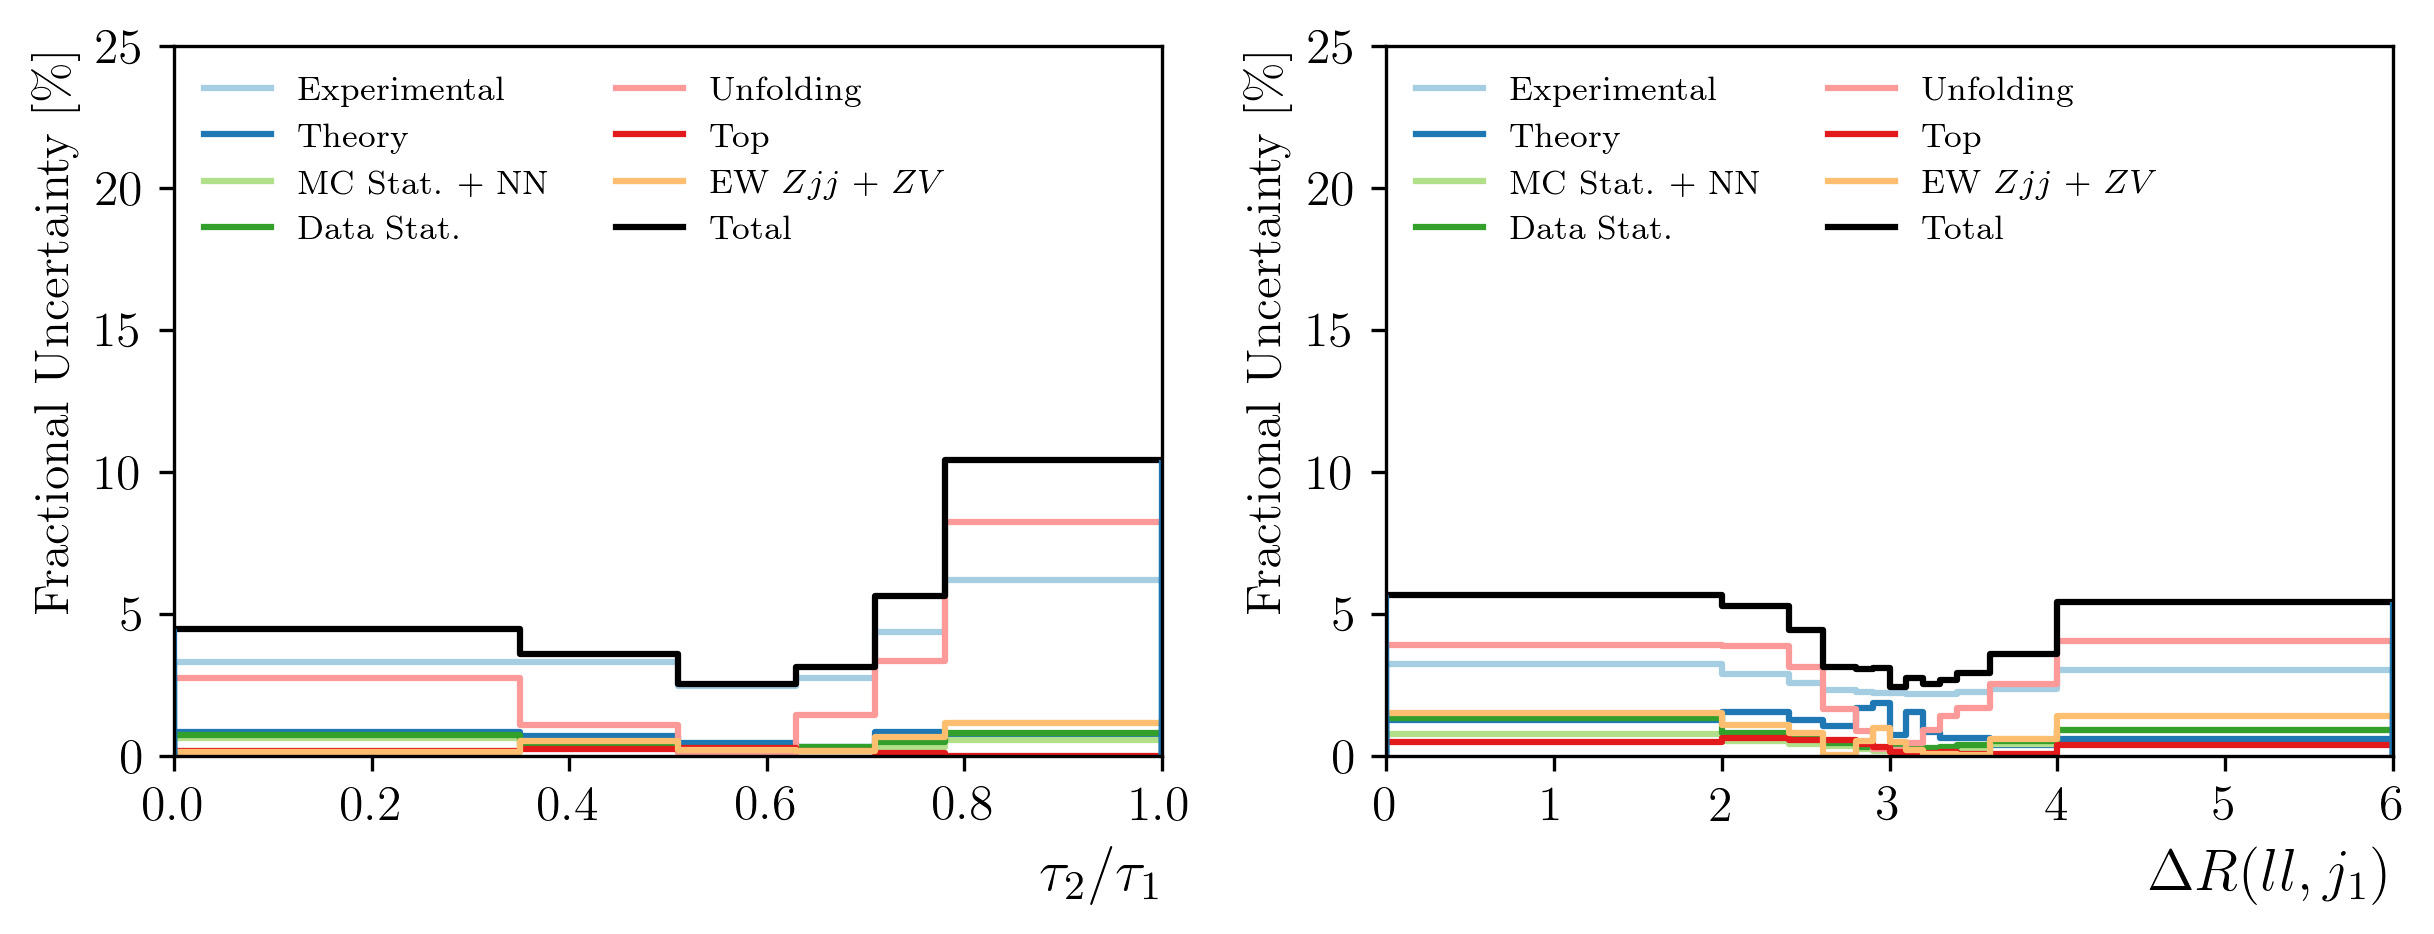

In [12]:
n_derived_vars = len(labels) - 24 

fig = plt.figure(figsize=(4*n_derived_vars,3), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(1, n_derived_vars)

for i, subfig in enumerate(subfigs.flat):
    i = i+24 # skip to derived variables
    ax = subfig.subplots(1, 1)
    colors = [plt.cm.Paired(i) for i in range(20)]
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])

    ax.step(bins, np.concatenate([[uncertainties[var+'_exp'][0]],uncertainties[var+'_exp']]),              label = "Experimental",       color=colors[0],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_theory'][0]],uncertainties[var+'_theory']]),        label = "Theory",             color=colors[1],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_mc_stat'][0]],uncertainties[var+'_mc_stat']]),      label = "MC Stat. + NN",      color=colors[2],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_data_stat'][0]],uncertainties[var+'_data_stat']]),  label = "Data Stat.",         color=colors[3],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_unfolding'][0]],uncertainties[var+'_unfolding']]),  label = "Unfolding",          color=colors[4]     )
    ax.step(bins, np.concatenate([[uncertainties[var+'_top'][0]],uncertainties[var+'_top']]),              label = "Top",                color=colors[5],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_nonDY'][0]],uncertainties[var+'_nonDY']]),          label = r"EW $Zjj$ + $ZV$",   color=colors[6],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_total'][0]],uncertainties[var+'_total']]),          label = "Total",              color='black',      )

    ### draw lines at the beginning and end of the first and last bins, for plotting purposes
    label_list = ['exp', 'theory', 'mc_stat', 'data_stat', 'unfolding', 'top', 'nonDY', 'total']
    for label in label_list:
        plt.vlines(x=bins[0], ymin=0, ymax=uncertainties[var+'_'+label][0])
        plt.vlines(x=bins[-1], ymin=0, ymax=uncertainties[var+'_'+label][-1])

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylabel(r"Fractional Uncertainty [\%]", fontsize=12, loc='top')
    ax.legend(fontsize=8, loc='upper left', ncol=2, frameon=False)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 25])
    ax.set_xlabel(plot_labels[var], fontsize=14, loc='right');
        
plt.savefig(os.path.join(plot_dir,"total_systs_derived.pdf"))

### Plot results

Plots: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


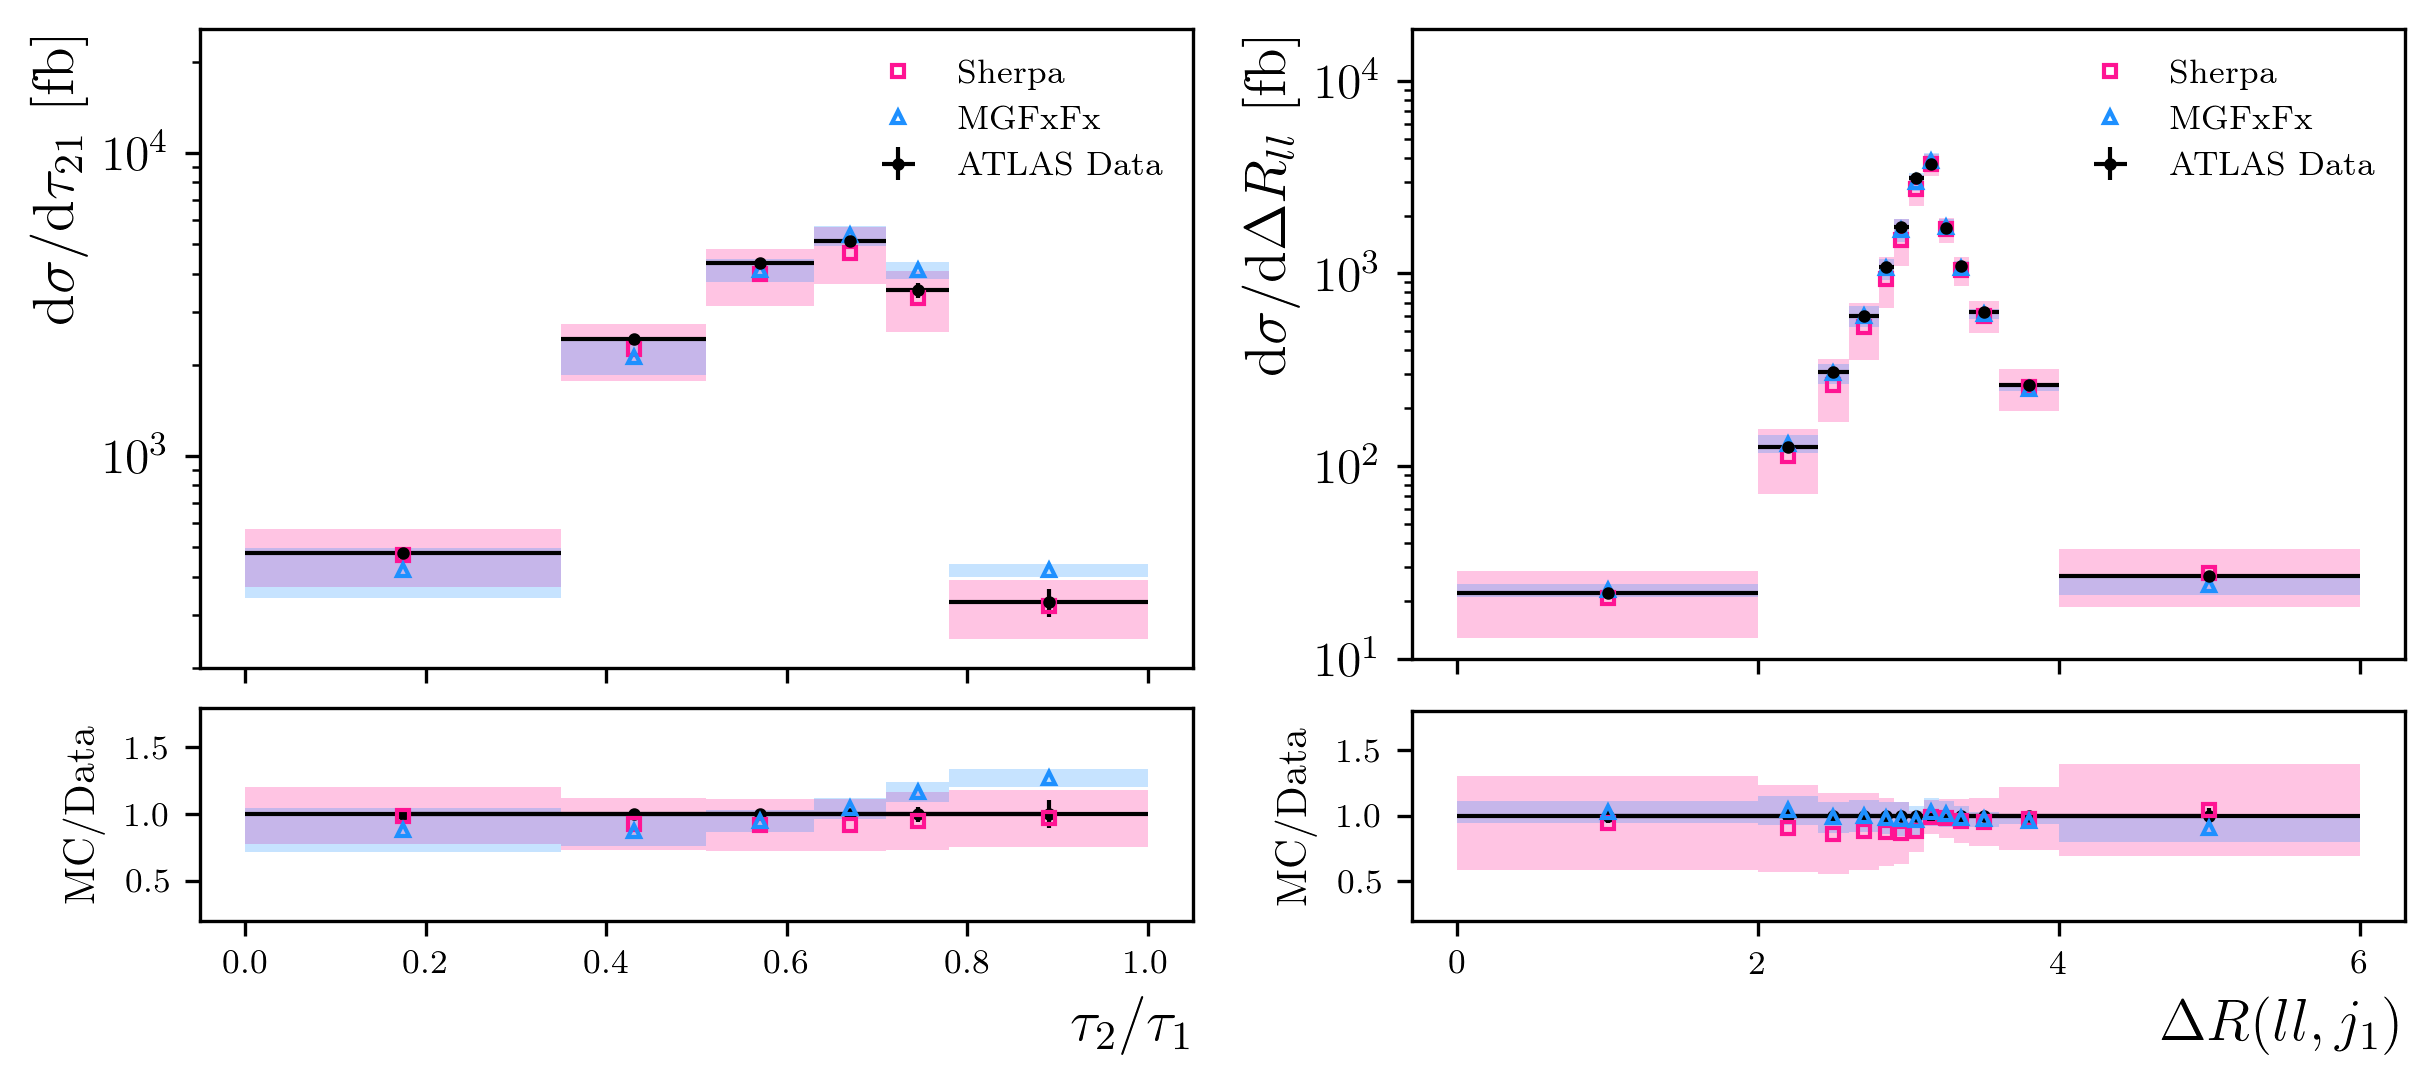

In [13]:
fig = plt.figure(figsize=(4*n_derived_vars,3.5), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(1, n_derived_vars)

lumi = 138.96 

for i, subfig in enumerate(tqdm(subfigs.flat, desc="Plots")):
    i = i+24 # skip to derived variables 
    axs = subfig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})

    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])
     
    if var == "tau21" or var == "dR_ll": 
        df = multifold[mask_trackj1]
    else:
        df = multifold    
        
    ### Sherpa
    counts = mc_preds[i]['sherpa_counts']
    sherpa_density = counts/lumi/bin_widths
    sherpa_error = mc_preds[i]['sherpa_err']/mc_preds[i]['sherpa_counts']
    _ = make_error_boxes(axs[0], bin_centers, sherpa_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([sherpa_density*sherpa_error, sherpa_density*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label='Sherpa')

    ### MGFxFx 
    counts = mc_preds[i]['mgfxfx_counts']
    mgfxfx_density = counts/lumi/bin_widths
    mgfxfx_error = mc_preds[i]['mgfxfx_err']/mc_preds[i]['mgfxfx_counts']
    _ = make_error_boxes(axs[0], bin_centers, mgfxfx_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([mgfxfx_density*mgfxfx_error, mgfxfx_density*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label='MGFxFx')
    
    ### MultiFolded Data
    multifold_density, _, _ = axs[0].hist(df[var], bins=bins, density=True, weights=df.weights_nominal, color='k', alpha=0)
    multifold_density *= np.sum(multifold.weights_nominal)
    axs[0].errorbar(bin_centers, multifold_density, xerr=bin_widths/2, yerr=multifold_density*uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label="ATLAS Data", markersize=4, linewidth=1)
    
    axs[0].xaxis.set_tick_params(labelsize=12)
    axs[0].yaxis.set_tick_params(labelsize=12)
    axs[0].set_ylabel(labels[var], fontsize=14, loc='top')
    axs[0].legend(fontsize=8, frameon=False)
    axs[0].set_yscale('log')

    if var == 'tau21':
        axs[0].set_ylim([200, 5*max(max(sherpa_density), max(multifold_density))])
    elif var == 'dR_ll':
        axs[0].set_ylim([10, 5*max(max(sherpa_density), max(multifold_density))])
            
    axs[1].errorbar(bin_centers, np.ones(len(bin_centers)), xerr=bin_widths/2, yerr=uncertainties[var+"_total"]/100, marker=".", color="k", alpha=1, ecolor='k', markersize=4, linewidth=1)
    _ = make_error_boxes(axs[1], bin_centers, sherpa_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(sherpa_density/multifold_density)*sherpa_error, (sherpa_density/multifold_density)*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label='Sherpa')
    _ = make_error_boxes(axs[1], bin_centers, mgfxfx_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(mgfxfx_density/multifold_density)*mgfxfx_error, (mgfxfx_density/multifold_density)*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label='MGFxFx')
    axs[1].set_ylim([0.2,1.8])
    axs[1].set_ylabel('MC/Data', fontsize=10, labelpad=5)
    axs[1].set_xlabel(plot_labels[var], fontsize=14, loc='right');
plt.savefig(os.path.join(plot_dir,"derived_diff_xsec_data.pdf"))

# tau21 with a tau1 > 0.1 cut

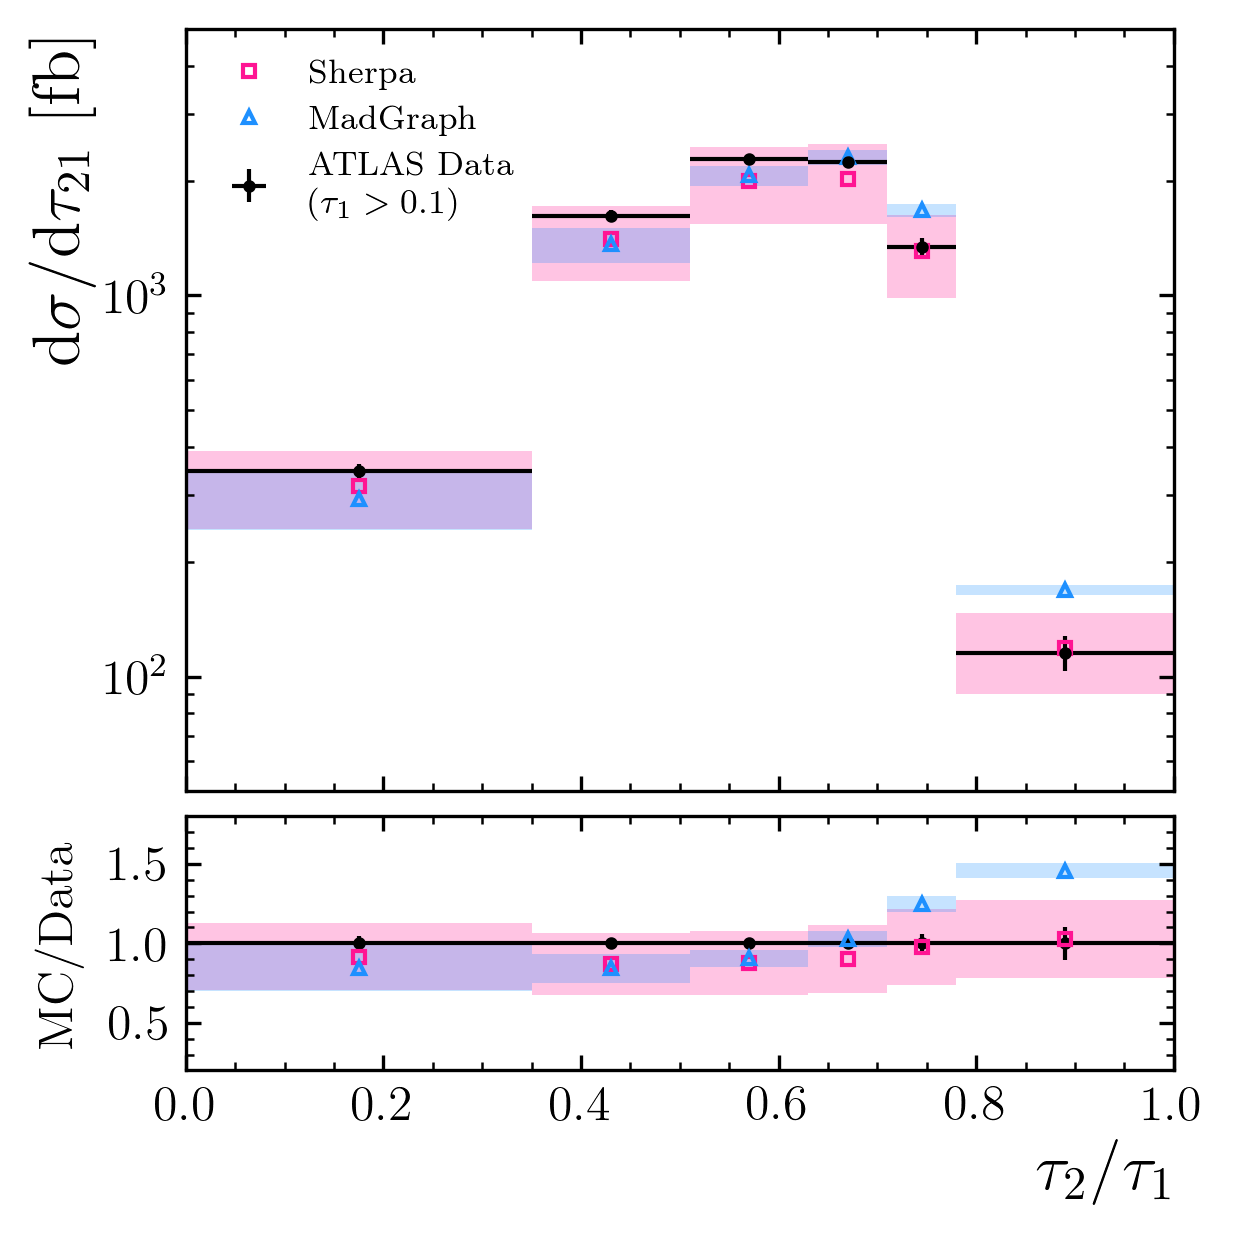

In [14]:
mc_preds_tau1_01 = np.load(os.path.join(folder,"mc_preds_tau1_01.npy"), allow_pickle=True)

vars = [24]

def tau1_cut(df, tau1_cut=0.1):
    return df[(df.pT_trackj1 > 5) & (df.tau1_trackj1 > tau1_cut)]

for i in range(len(vars)):
    fig = plt.figure(figsize=(4,4), dpi=300, constrained_layout=True)
    axs = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})

    var = list(bins_dict.items())[vars[i]][0]
    bins = np.array(list(bins_dict.items())[vars[i]][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])

    df = tau1_cut(multifold[mask_trackj1])
        
    ### Sherpa
    counts = mc_preds_tau1_01[vars[i]]['sherpa_counts']
    sherpa_density = counts/lumi/bin_widths
    sherpa_error = mc_preds_tau1_01[vars[i]]['sherpa_err']/mc_preds_tau1_01[vars[i]]['sherpa_counts']
    _ = make_error_boxes(axs[0], bin_centers, sherpa_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([sherpa_density*sherpa_error, sherpa_density*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label=r'Sherpa')

    ### MGFxFx 
    counts = mc_preds_tau1_01[vars[i]]['mgfxfx_counts']
    mgfxfx_density = counts/lumi/bin_widths
    mgfxfx_error = mc_preds_tau1_01[vars[i]]['mgfxfx_err']/mc_preds[vars[i]]['mgfxfx_counts']
    _ = make_error_boxes(axs[0], bin_centers, mgfxfx_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([mgfxfx_density*mgfxfx_error, mgfxfx_density*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label=r'MadGraph')

    ### MultiFold
    multifold_density, _, _ = axs[0].hist(df[var], weights=df.weights_nominal, bins=bins, color='black', linewidth= 2, density=True, alpha=0)
    multifold_density *= np.sum(df.weights_nominal)
    axs[0].errorbar(bin_centers, multifold_density, xerr=bin_widths/2, yerr=multifold_density*uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label=r"ATLAS Data"+"\n"+r"$(\tau_1 > 0.1)$", markersize=4, linewidth=1)

    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[0].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[0].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[0].set_ylabel(labels[var], fontsize=16, labelpad=2, loc='top')
    axs[0].set_yscale('log')
    axs[0].set_ylim([50, 5000]) 
    axs[0].legend(frameon=False, loc='best')

    axs[1].errorbar(bin_centers, np.ones(len(bin_centers)), xerr=bin_widths/2, yerr=uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1,  ecolor='k', markersize=4, linewidth=1)
    _ = make_error_boxes(axs[1], bin_centers, sherpa_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(sherpa_density/multifold_density)*sherpa_error, (sherpa_density/multifold_density)*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s",)
    _ = make_error_boxes(axs[1], bin_centers, mgfxfx_density/multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(mgfxfx_density/multifold_density)*mgfxfx_error, (mgfxfx_density/multifold_density)*mgfxfx_error]), facecolor='dodgerblue', alpha=0.25, marker="^",)
    axs[1].set_xlim(bins[0], bins[-1])
    axs[1].set_ylim([0.2,1.8])
    axs[1].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[1].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[1].set_ylabel('MC/Data', fontsize=12, labelpad=6, loc='center')
    axs[1].set_xlabel(plot_labels[var], fontsize=16, labelpad=2, loc='right');

    plt.savefig(os.path.join(plot_dir,"tau21_cut.pdf".format(i)))

# Average $m_{j_1}$ in bins of $p_{T}^{j_1}$

In [15]:
def bin_cut(df, bins, i):
    return df[((df.pT_trackj1 > bins[i]) & (df.pT_trackj1 <= bins[i+1]))]

df = multifold[mask_trackj1]
df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
df_nonDY = multifold_nonDY[mask_nonDY_trackj1]

bins = bins_dict['pT_trackj1']

### calculate central values
means = np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i).weights_nominal) for i in range(len(bins)-1)])
means_mc = np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i).weight_mc) for i in range(len(bins)-1)])

### calculate the experimental & theory uncertainties
regular_uncert = np.zeros(len(bins)-1)
uncerts_list = ['weights_pileup','weights_muEffReco','weights_muEffIso','weights_muEffTrack','weights_muEffTrig','weights_muCalID','weights_muCalMS','weights_muCalResBias','weights_muCalScale','weights_trackEffMain','weights_trackEffJet','weights_trackFake','weights_trackPtScale','weights_theoryPSjet','weights_theoryPSsoft','weights_theoryMPI','weights_theoryPSscale','weights_theoryAlphaS','weights_theoryQCD','weights_theoryPDF','weights_topBackground','weights_lumi']
for uncert in tqdm(uncerts_list, desc="Exp. & theory uncertainties"):
    regular_uncert += (np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i)[uncert]) for i in range(len(bins)-1)]) - means)**2
uncert = 100*np.sqrt(regular_uncert)/means

### calculate the non-strong uncertainty 
nonstrong_uncert = 100*np.sqrt((np.array([np.average(bin_cut(df_nonDY, bins, i).m_trackj1, weights=bin_cut(df_nonDY, bins, i).weights_nominal) for i in range(len(bins)-1)]) - means)**2)/means

### calculate the unfolding uncertainties 
hv_uncert = 100*np.sqrt((np.array([np.average(bin_cut(df_sherpa, bins, i).m_trackj1, weights=bin_cut(df_sherpa, bins, i).weights_nominal) for i in range(len(bins)-1)]) - means)**2)/means
dd_target_means = np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i).target_dd) for i in range(len(bins)-1)])
dd_uncert = 100*np.sqrt((np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i).weights_dd) for i in range(len(bins)-1)]) - dd_target_means)**2)/dd_target_means

### calculate MC stat uncertainty w/ bootstraps 
mc_bootstraps = [] 
for bootstrap in tqdm([key for key in df.keys() if key.startswith("weights_bootstrap_mc")], desc="MC stat uncertainty"):
    mc_bootstraps.append(np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i)[bootstrap]) for i in range(len(bins)-1)]))
mc_bootstraps = np.array(mc_bootstraps)
mc_bootstrap_uncert = 100*np.std(mc_bootstraps, axis=0)/means_mc
mc_bootstrap_uncert_multifold = 100*np.std(mc_bootstraps, axis=0)/means

### calculate data stat uncertainty w/ bootstraps 
data_bootstraps = [] 
for bootstrap in tqdm([key for key in df.keys() if key.startswith("weights_bootstrap_data")], desc="Data stat uncertainty"):
    data_bootstraps.append(np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i)[bootstrap]) for i in range(len(bins)-1)]))
data_bootstraps = np.array(data_bootstraps)
data_bootstrap_uncert = 100*np.std(data_bootstraps, axis=0)/means

### calculate nn stat uncertainty w/ ensembles 
nn_ensembles = [] 
for ensemble in tqdm([key for key in df.keys() if key.startswith("weights_ensemble")], desc="NN initialization uncertainty"):
    nn_ensembles.append(np.array([np.average(bin_cut(df, bins, i).m_trackj1, weights=bin_cut(df, bins, i)[ensemble]) for i in range(len(bins)-1)]))
nn_ensembles = np.array(nn_ensembles)
nn_ensemble_uncert = 100*1.253*np.std(nn_ensembles, axis=0)/means/np.sqrt(100) # 1.253 factor is because we need the std err on median, not mean

### combine all uncertainties
total_uncert = np.sqrt(uncert**2 + nonstrong_uncert**2 + hv_uncert**2 + dd_uncert**2 + mc_bootstrap_uncert_multifold**2 + data_bootstrap_uncert**2 + nn_ensemble_uncert**2)

### MC predictions (note that uncertainties are absolute) 
# MG 
mg_values = np.array([4.723, 8.718, 11.973, 14.406, 17.477, 24.716])
mg_uncert = np.array([0.1030, 0.1480, 0.3060, 0.4870, 0.6791, 1.0711])

# Sherpa
sherpa_values = np.array([4.293, 8.31, 11.483, 13.808, 16.836, 24.294])
sherpa_uncert = np.array([0.1404, 0.1632, 0.2627, 0.3826, 0.6216, 1.0773])

NN initialization uncertainty: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


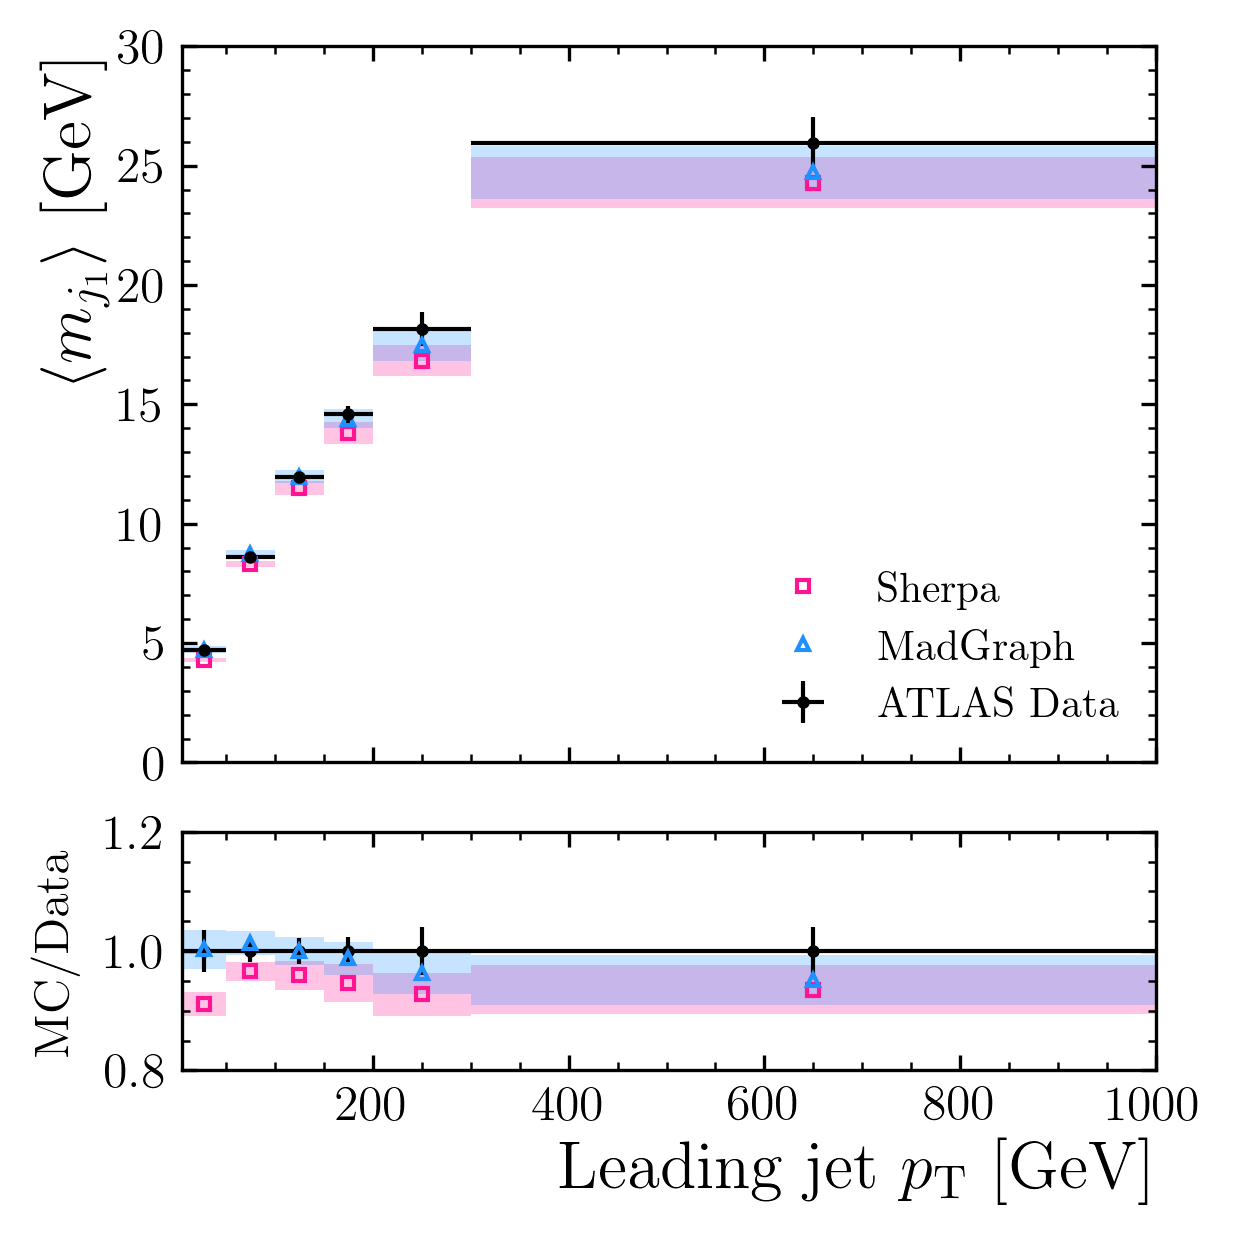

In [16]:
### plot
fig, axs = plt.subplots(2, 1, figsize=(4,4), dpi=300, constrained_layout=True, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})
bins = np.array(bins_dict['pT_trackj1'])
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])

axs[0].minorticks_on()
axs[0].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
axs[0].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
axs[0].set_ylabel(r'$\langle m_{j_1}\rangle$ [GeV]', fontsize=16, labelpad=2, loc='top')
axs[0].set_ylim([0, 30])

### Sherpa
sherpa_error = mg_uncert/mg_values
_ = make_error_boxes(axs[0], bin_centers, sherpa_values, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([sherpa_values*sherpa_error, sherpa_values*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", label=r'Sherpa')

### MGFxFx 
mg_error = sherpa_uncert/sherpa_values
_ = make_error_boxes(axs[0], bin_centers, mg_values, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([mg_values*mg_error, mg_values*mg_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label=r'MadGraph')

axs[0].errorbar(bin_centers, means, xerr=bin_widths/2, yerr=means*total_uncert/100, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label=r"ATLAS Data", markersize=4, linewidth=1)
axs[0].set_xlim(bins[0], bins[-1])
                 
axs[1].errorbar(bin_centers, np.ones(len(bin_centers)), xerr=bin_widths/2, yerr=total_uncert/100, marker=".", linestyle="None", color="k", alpha=1,  ecolor='k',markersize=4, linewidth=1)
_ = make_error_boxes(axs[1], bin_centers, sherpa_values/means, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(sherpa_values/means)*sherpa_error, (sherpa_values/means)*sherpa_error]), facecolor='deeppink', alpha=0.25, marker="s", )
_ = make_error_boxes(axs[1], bin_centers, mg_values/means, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(mg_values/means)*mg_error, (mg_values/means)*mg_error]), facecolor='dodgerblue', alpha=0.25, marker="^")

axs[0].legend(fontsize=10, frameon=False, loc='best');

axs[1].minorticks_on()
axs[1].set_xlim(bins[0], bins[-1])
axs[1].set_ylim([0.8,1.2])
axs[1].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
axs[1].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
axs[1].set_ylabel('MC/Data', fontsize=12, labelpad=6, loc='center')
axs[1].set_xlabel(r'Leading jet $p_\text{T}$ [GeV]', fontsize=16, labelpad=2, loc='right');

plt.savefig("./plots/data/ave_mj1_vs_pt.pdf")

# Uncertainty correlation matrices

In [17]:
def duo_plots(index_range=np.arange(24)):
    for i in tqdm(index_range): # number of observables to plot
        fig = plt.figure(figsize=(4*2,3), dpi=300, constrained_layout=True)
        subfigs = fig.subfigures(1, 2, width_ratios=[1, 1.5])

        for j, subfig in enumerate(subfigs.flat):

            if j == 0: # left figure 
                ax = subfig.subplots(1, 1)
                colors = [plt.cm.Paired(i) for i in range(20)]
                var = list(bins_dict.items())[i][0]
                bins = np.array(list(bins_dict.items())[i][1])
                bin_centers = 0.5 * (bins[1:] + bins[:-1])

                ax.set_ylim([0, 25])
                loc = 'upper left'
                    
                ax.step(bins, np.concatenate([[uncertainties[var+'_exp'][0]],uncertainties[var+'_exp']]),              label = "Experimental",       color=colors[0],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_theory'][0]],uncertainties[var+'_theory']]),        label = "Theory",             color=colors[1],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_mc_stat'][0]],uncertainties[var+'_mc_stat']]),      label = "MC Stat. + NN",      color=colors[2],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_data_stat'][0]],uncertainties[var+'_data_stat']]),  label = "Data Stat.",         color=colors[3],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_unfolding'][0]],uncertainties[var+'_unfolding']]),  label = "Unfolding",          color=colors[4]     )
                ax.step(bins, np.concatenate([[uncertainties[var+'_top'][0]],uncertainties[var+'_top']]),              label = "Top",                color=colors[5],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_nonDY'][0]],uncertainties[var+'_nonDY']]),          label = r"EW $Zjj$ + $ZV$",   color=colors[6],    )
                ax.step(bins, np.concatenate([[uncertainties[var+'_total'][0]],uncertainties[var+'_total']]),          label = "Total",              color='black',      )

                ### draw lines at the beginning and end of the first and last bins, for plotting purposes
                label_list = ['exp', 'theory', 'mc_stat', 'data_stat', 'unfolding', 'top', 'nonDY', 'total']
                for label in label_list:
                    plt.vlines(x=bins[0], ymin=0, ymax=uncertainties[var+'_'+label][0])
                    plt.vlines(x=bins[-1], ymin=0, ymax=uncertainties[var+'_'+label][-1])

                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)
                ax.set_ylabel(r"Fractional Uncertainty [\%]", fontsize=10, labelpad=4, loc='top')
                ax.legend(fontsize=7, loc=loc, ncol=2, frameon=False)
                ax.set_xlabel(plot_labels[var], fontsize=12, labelpad=2, loc='right');
                ax.set_xlim([bins[0], bins[-1]])

            elif j == 1: # right figure
                ax = subfig.subplots(1, 1)
                v_corr = corr_matrix(var, bins_dict, multifold, multifold_sherpa, multifold_nonDY)
                      
                from matplotlib.colors import ListedColormap
                N = 17
                vals = np.ones((N, 4))
                vals[:, 0] = np.array([0.2082,0.1337,0.0592,0.0686,0.078,0.0506,0.0232,0.1017,0.1802,0.35515,0.5301,0.67435,0.8186,0.9071,0.9956,0.986,0.9764])
                vals[:, 1] = np.array([0.1664,0.26315,0.3599,0.432,0.5041,0.573,0.6419,0.67985,0.7178,0.7335,0.7492,0.741,0.7328,0.7595,0.7862,0.8847,0.9832])
                vals[:, 2] = np.array([0.5293,0.69885,0.8684,0.85345,0.8385,0.81495,0.7914,0.71695,0.6425,0.55435,0.4662,0.40805,0.3499,0.27335,0.1968,0.12535,0.0539])
                newcmp = ListedColormap(vals, name='kBird')
                
                im = ax.imshow(v_corr, cmap=newcmp, aspect=0.66) # cmap='coolwarm', aspect=0.66
                cbar = fig.colorbar(im, ax=ax)
                cbar.mappable.set_clim(-1,1)

                ax.set_title(r"Correlation Matrix: {}".format(plot_labels[var])) 

                if i in [0, 1]: # integer bins
                    x_labels = ["("+str(int(bins[i]))+", "+str(int(bins[i+1]))+")" for i in range(len(bins)-1)]
                else:
                    x_labels = ["({:.2f},{:.2f})".format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

                ax.set_xticks(np.arange(len(x_labels)), x_labels, rotation=30)
                ax.set_yticks(np.arange(len(x_labels)), x_labels)
                ax.invert_yaxis()

                ### add labels directly to plot
                for i in range(v_corr.shape[0]):
                    for j in range(v_corr.shape[1]):
                        text = ax.text(j, i, "{:.2f}".format(v_corr[i, j]), size=6, ha="center", va="center", color="black")

        plt.savefig(os.path.join(plot_dir,"duo_{}.pdf".format(var)))

100%|██████████| 2/2 [00:21<00:00, 10.58s/it]


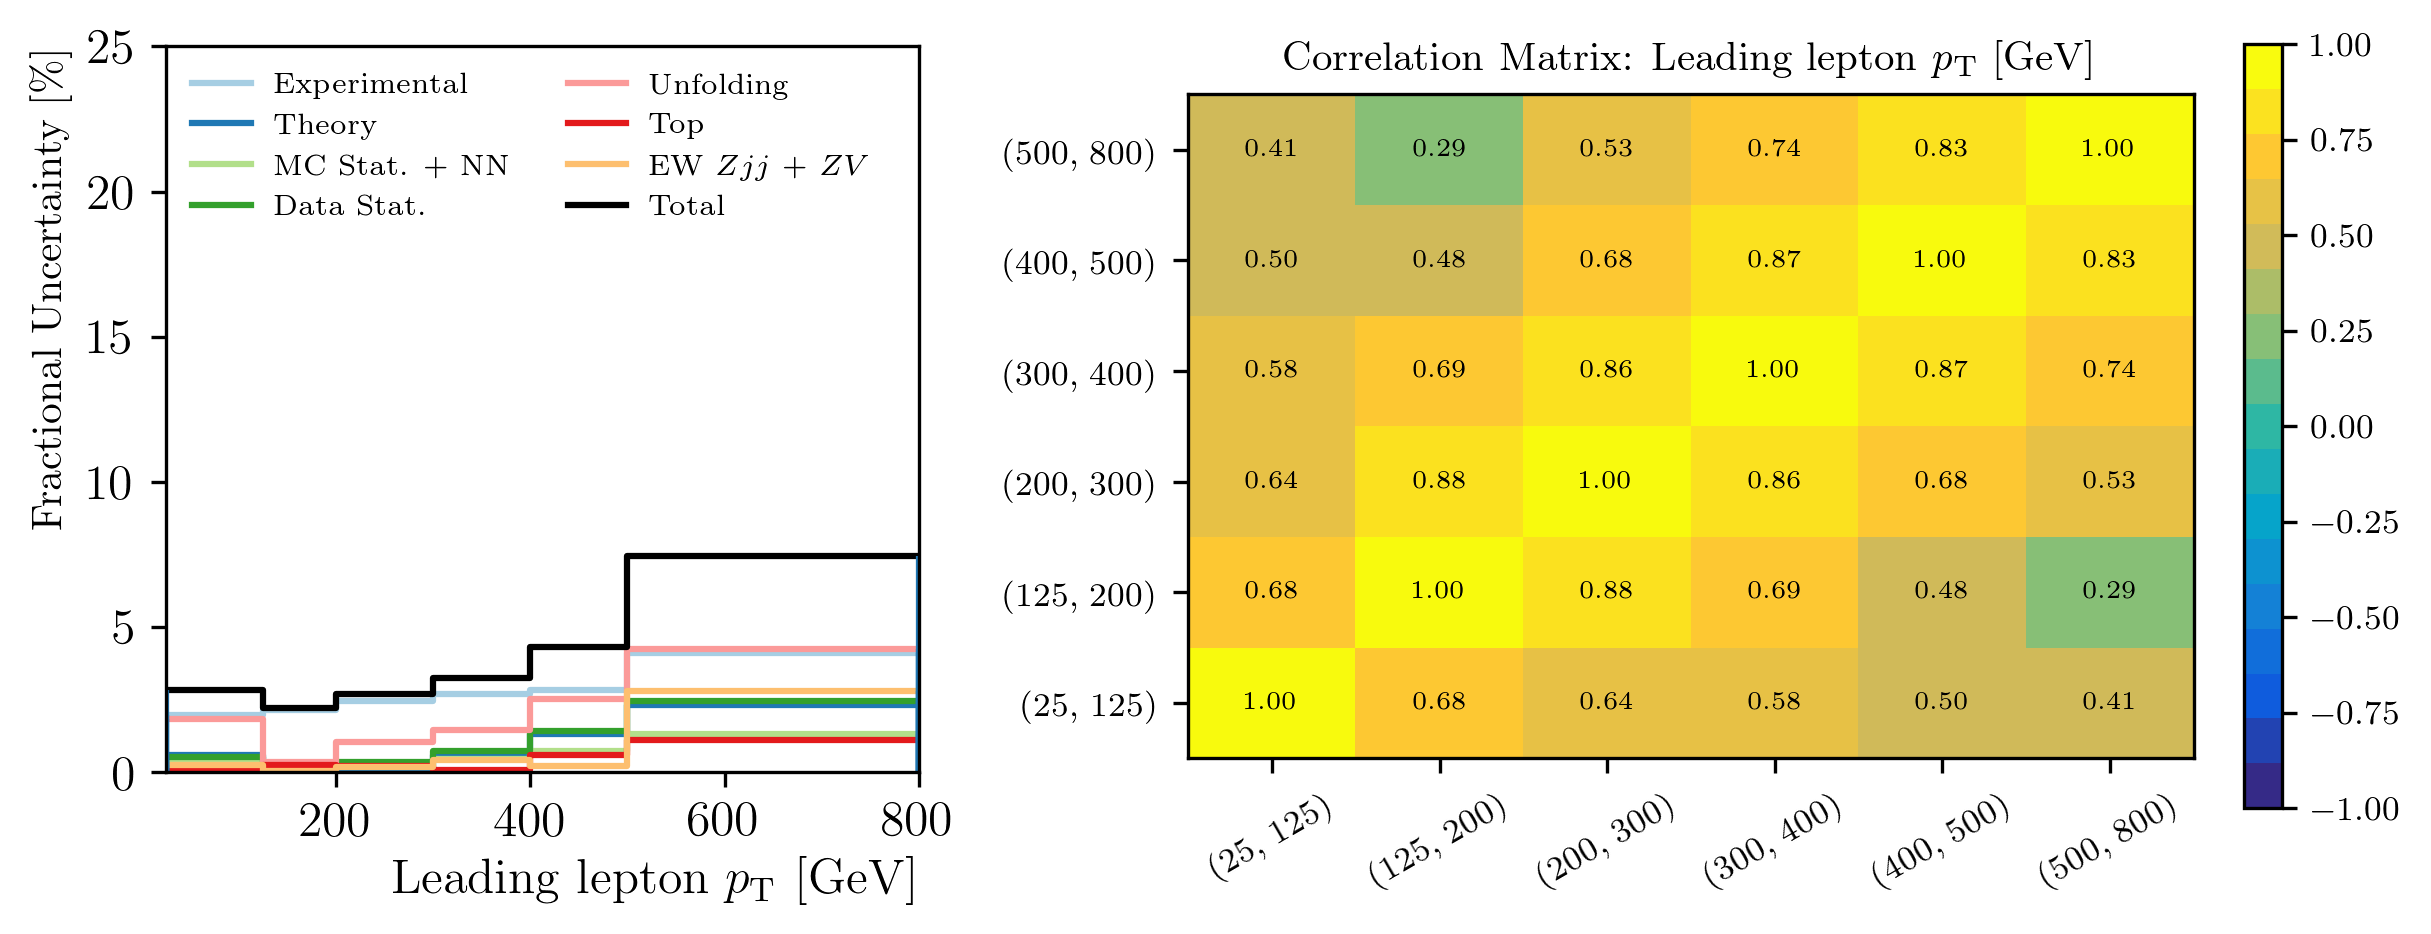

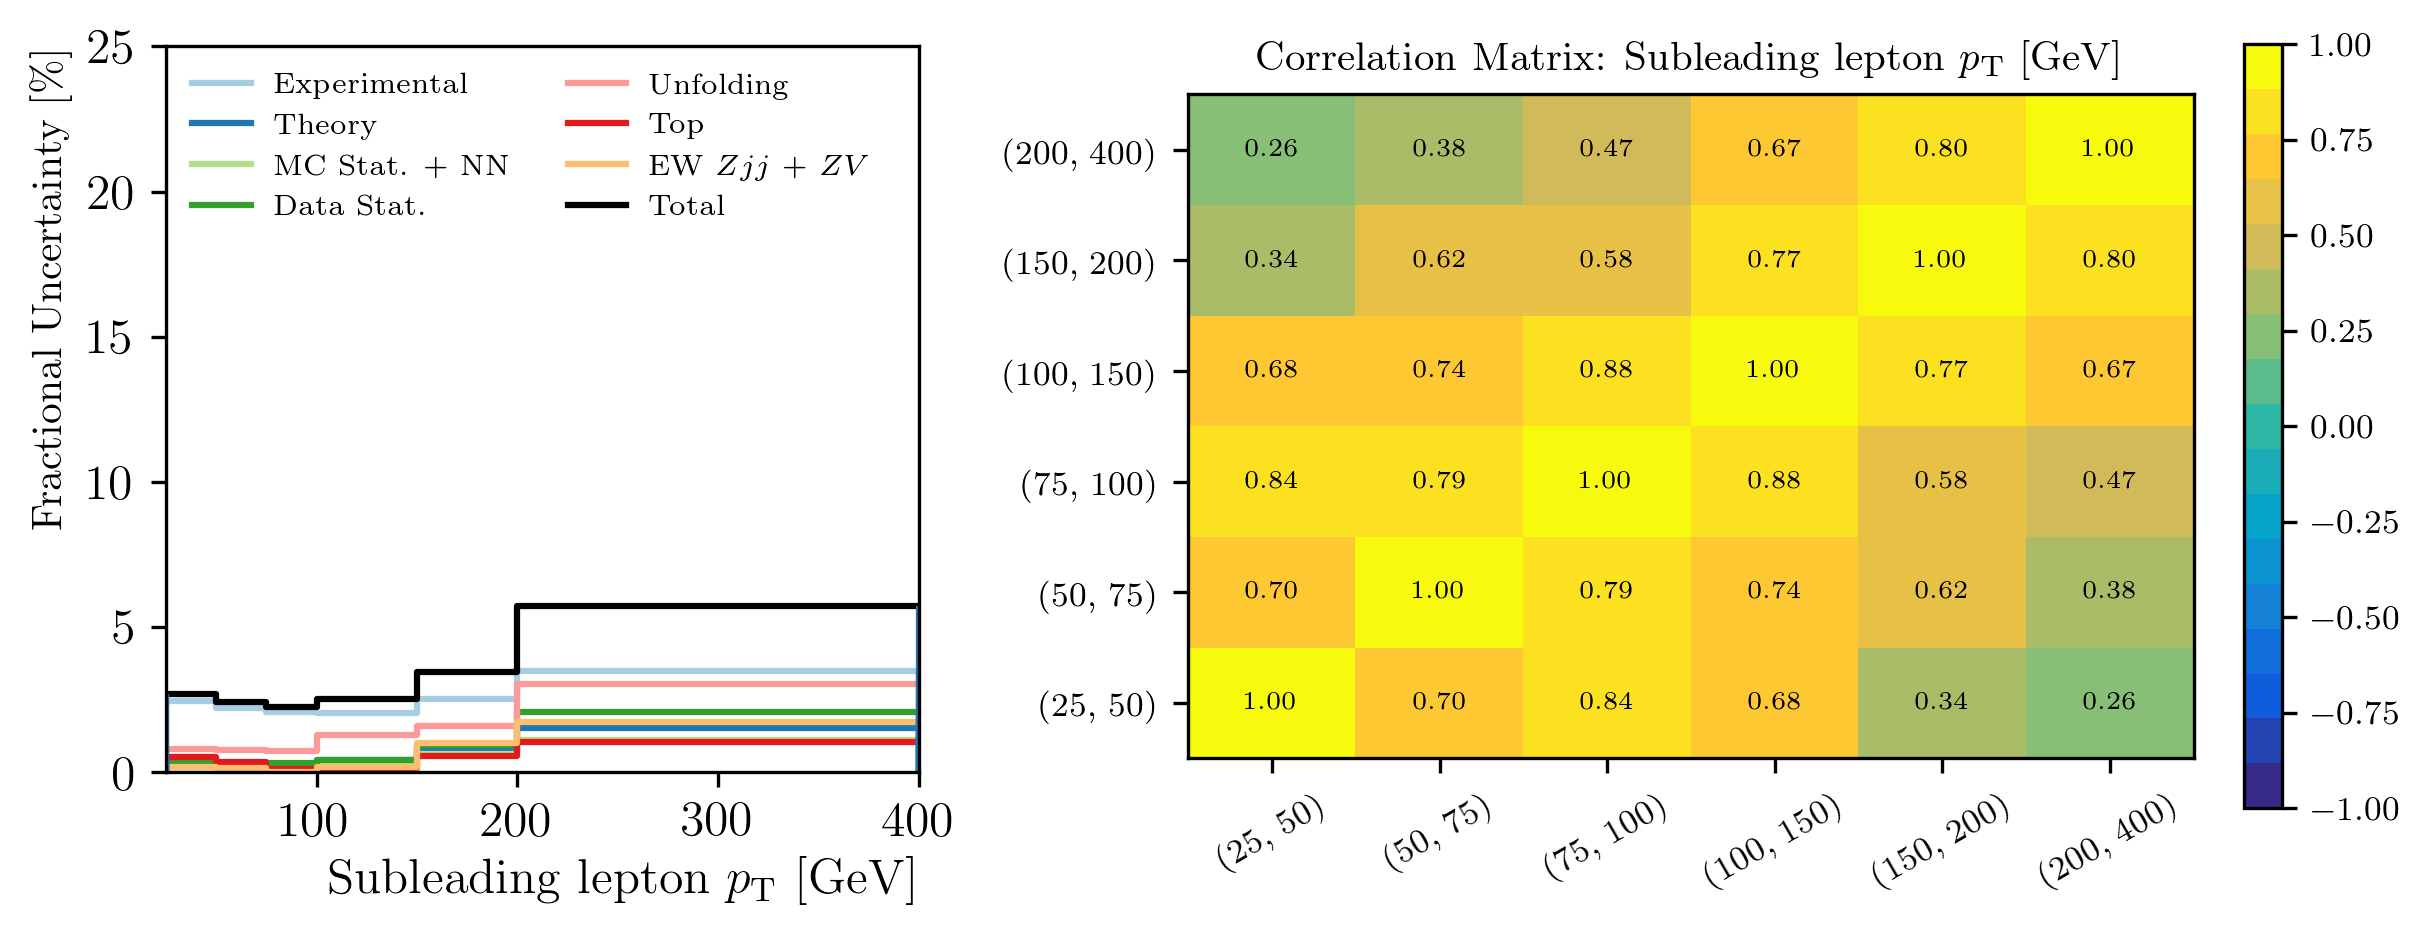

In [18]:
duo_plots([0, 1])